In [ ]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip install top2vec
!pip install umap-learn[plot]

In [26]:
import json
import requests
import umap
import umap.plot
import hdbscan
from top2vec import Top2Vec
from konlpy.tag import Mecab
mecab = Mecab()

In [16]:
url = 'http://tools.kinds.or.kr:8888/search/news'

datas = {
    "access_key": "9af2f705-2974-4340-8b55-d69040b944ab",

    "argument": {
        "query": {"title":""},
        "published_at": {
            "from": "2021-08-29",
            "until": "2021-10-06"
            },
            "provider": [],
            "category": ["008004000"],
            "category_incident": [""],
            "byline": "",
            "provider_subject": [""],
            "subject_info": [""],
            "subject_info1": [""],
            "subject_info2": [""],
            "subject_info3": [""],
            "subject_info4": [""],
            "sort": {"date": "asc"},
            "hilight": 200,
            "return_from": 0,
            "return_size": 100000,
            "fields": [
                "byline",
                "category",
                "category_incident",
                "provider_news_id",
                "hilight",
                ]
                }
         }

response = requests.post(url, data=json.dumps(datas))
js=response.json()

In [17]:
total_hits = js['return_object']['total_hits']
print("결과 개수:",total_hits)

결과 개수: 9652


In [22]:
# 모든 타이틀
titles, hilights ,ths, news_ids= [], [], [],[]
for i in range(total_hits):
    title = js['return_object']['documents'][i]['title']
    hilight = js['return_object']['documents'][i]['hilight']
    news_id = js['return_object']['documents'][i]['news_id']
    news_ids.append(news_id)
    th = title +","+ hilight

    #titles.append(title)
    #hilights.append(hilight)
    ths.append(th)
len(ths)

9652

In [23]:
model = 0
model = Top2Vec(documents = ths, tokenizer = mecab.morphs, umap_args = {'n_neighbors': 15, 'n_components': 5, 'metric': 'cosine', "random_state": 42})

2021-10-10 18:41:34,633 - top2vec - INFO - Pre-processing documents for training
2021-10-10 18:41:39,362 - top2vec - INFO - Creating joint document/word embedding
2021-10-10 18:43:30,728 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-10-10 18:44:26,278 - top2vec - INFO - Finding dense areas of documents
2021-10-10 18:44:26,710 - top2vec - INFO - Finding topics


In [24]:
# https://github.com/ddangelov/Top2Vec/blob/master/top2vec/Top2Vec.py
# line 360
model._get_document_vectors()

array([[ 0.00085655, -0.06231509,  0.02077181, ..., -0.03674531,
        -0.04702259, -0.0499073 ],
       [-0.05026841, -0.0990666 , -0.05514856, ...,  0.06961371,
         0.02347579, -0.13283943],
       [ 0.02309601, -0.06197178, -0.01853498, ...,  0.01911485,
         0.04971993,  0.11442513],
       ...,
       [-0.09025084,  0.11449922,  0.00287058, ..., -0.07563678,
         0.01854234,  0.03142323],
       [-0.04913105,  0.03845198, -0.05748054, ...,  0.00062973,
         0.04021697, -0.00142685],
       [-0.04483226, -0.0326921 ,  0.04247523, ...,  0.01863139,
        -0.08762548,  0.01963202]], dtype=float32)

In [27]:

umap_args = {'n_neighbors': 15,
             'n_components': 2,
             'metric': 'cosine'}

mapper = umap.UMAP(**umap_args).fit(model._get_document_vectors(norm=False))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


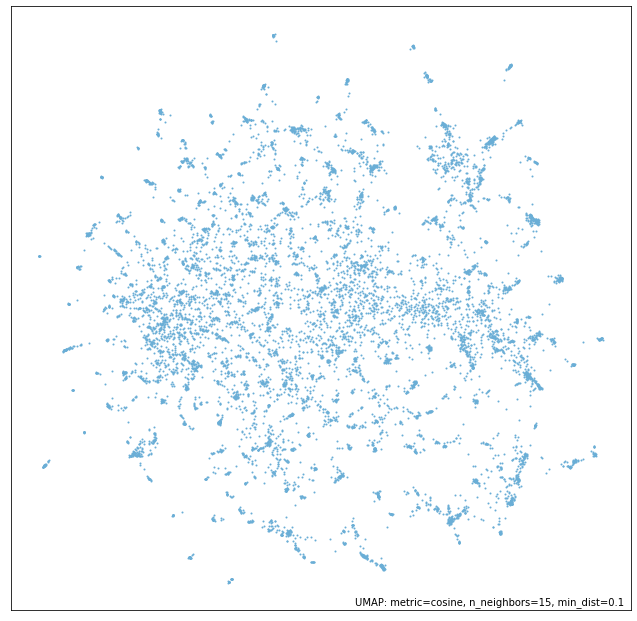

In [28]:
# https://umap-learn.readthedocs.io/en/latest/clustering.html
umap.plot.points(mapper,) 
# color_key {-1:'#000000',0:'#'}


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


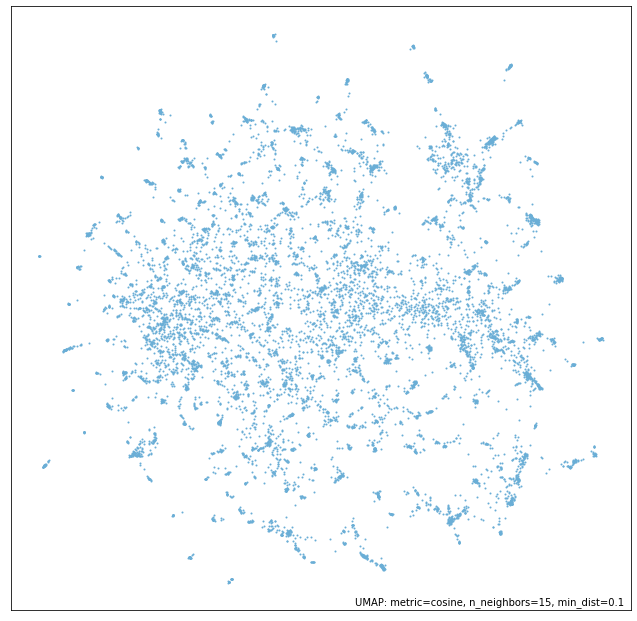

In [29]:
umap.plot.points(mapper,)

In [30]:
hdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(mapper.embedding_)

In [31]:

cluster.labels_

array([169, 172,  31, ...,  -1,  24, 170])

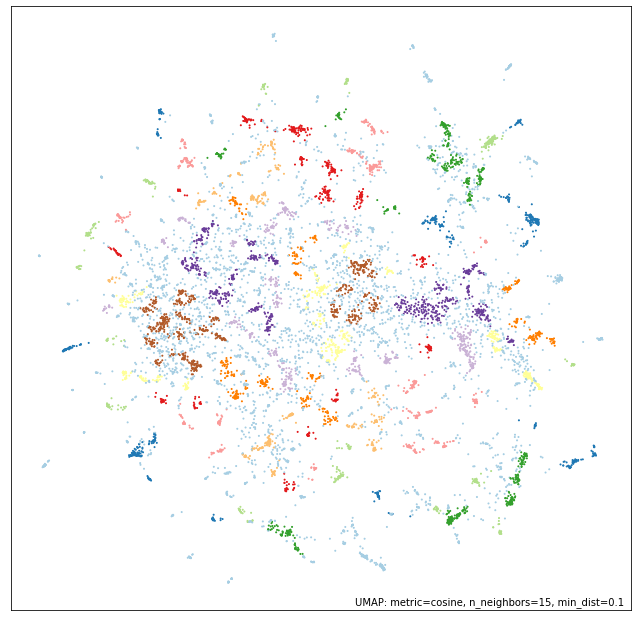

In [32]:
# https://github.com/ddangelov/Top2Vec/blob/master/top2vec/Top2Vec.py
# line 376
#
# https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
umap.plot.points(mapper,cluster.labels_, color_key_cmap='Paired',show_legend=False)

In [33]:
model.get_num_topics()

178

In [34]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [35]:
topic_sizes

array([313, 168, 158, 158, 141, 135, 131, 130, 126, 125, 117, 111, 107,
       107, 103,  98,  93,  92,  90,  85,  85,  84,  83,  82,  81,  77,
        76,  76,  75,  75,  74,  74,  72,  70,  70,  70,  70,  69,  68,
        66,  65,  65,  64,  63,  62,  62,  62,  61,  60,  60,  60,  60,
        59,  59,  58,  58,  58,  58,  57,  57,  57,  56,  56,  56,  55,
        54,  54,  54,  54,  53,  53,  52,  51,  51,  51,  51,  50,  50,
        50,  49,  48,  48,  48,  48,  47,  47,  46,  46,  44,  44,  43,
        43,  43,  42,  42,  42,  41,  41,  41,  41,  41,  40,  39,  39,
        39,  39,  39,  38,  38,  38,  38,  38,  38,  37,  37,  36,  36,
        36,  36,  36,  36,  36,  35,  34,  34,  34,  34,  34,  34,  34,
        33,  33,  33,  32,  32,  32,  32,  31,  31,  31,  31,  31,  30,
        30,  30,  30,  29,  29,  29,  29,  28,  28,  28,  28,  28,  28,
        27,  27,  27,  27,  27,  26,  25,  25,  25,  25,  25,  24,  24,
        24,  24,  22,  22,  22,  22,  22,  19,  17])

In [36]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=['넷플릭스'], num_topics=5)

In [37]:
topic_nums

array([  3, 103,  15,  33,  54])

In [38]:
topic_words, word_scores, topic_nums = model.get_topics()

In [40]:
topic_words[3]

array(['플릭스', '패트롤', '83', '집계', '순위', '오징어', '넷플릭스', '드라마', '개국', '차지',
       '오리지널', '올랐', '돌풍', '인도', '위', '오르', '세계', '현지', '일으키', '기록', '인기',
       'CNN', '작품', '황동혁', '기생충', '전', '게임', '사로잡', '오른', '시리즈', '사상',
       '동영상', 'OTT', '톱', '미국', '영국', '흥행', '이정재', '사이트', '456', '감독',
       '프랑스', '끌', '강세', '우드', '외신', '시간', '화제', '히트', '따르'], dtype='<U6')

In [41]:
topic_scores

array([0.50214388, 0.41439553, 0.40263792, 0.3783425 , 0.36156575])

In [42]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=3, num_docs=158)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    if score >= 0.4:
        print(f"Document: {doc_id}, Score: {score}")
        print("-----------")
        print(doc)
        print("-----------")
        print()

Document: 5886, Score: 0.8966195583343506
-----------
전세계가 푹 빠졌다…'오징어게임' 美 넷플릭스서 1위,전세계가 푹 빠졌다…'오징어게임' 美 넷플릭스서 1위 넷플릭스 오리지널 시리즈 ..'오징어 게임'이 전세계 넷플릭스 시리즈 인기 순위 2위에 오른 가운데 미국에서는 1위를 기록했다... .. .. .. ..22일 온라인동영상서비스(OTT) 콘텐츠 순위 집계 사이트인 플릭스 패트롤에 따르면 ..'오징어 게임'은 21일 넷플릭스 TV드라마 부문 ..'오늘의..
-----------

Document: 5987, Score: 0.8949527740478516
-----------
'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위,'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위 배우 이정재가 주연으로 나선 드라마 ..'오징어 게임'이 한국 작품 최초로 미국 넷플릭스에서 인기 작품 1위를 차지했습니다. .. ..넷플릭스 순위집계 사이트 플릭스 패트롤을 보면 ..'오징어 게임'은 미국에서 1위에 올랐고, 월드 랭킹 TV 쇼 부문에서도 2위를 기록했습니다. .. ..지금까지 한국..
-----------

Document: 6529, Score: 0.8743296265602112
-----------
'오징어 게임' 한국 드라마 최초 전 세계 넷플릭스 1위,'오징어 게임' 한국 드라마 최초 전 세계 넷플릭스 1위 넷플릭스 오리지널 시리즈 ..'오징어 게임'(감독 황동혁)이 한국 드라마 최초로 전 세계 넷플릭스 1위를 차지했다. .. ..24일(현지 시간) 글로벌 온라인 동영상 서비스(OTT) 순위 집계 사이트 플릭스 패트롤에 따르면 오징어게임이 ..'넷플릭스 인기 TV 프로그램 톱10' 세계 1위로 올랐다..
-----------

Document: 6498, Score: 0.8719534277915955
-----------
글로벌 열풍…'오징어게임' 전세계 넷플릭스 드라마 1위,글로벌 열풍…'오징어게임' 전세계 

In [43]:
def keyword_extract(doc):
    url = 'http://tools.kinds.or.kr:8888/feature'

    datas = {
        "access_key": "9af2f705-2974-4340-8b55-d69040b944ab",
        "argument": {
            "title": "", 
            "sub_title": "", 
            "content": 
            f"""
            {doc}
            """
            }
    }

    response = requests.post(url, data=json.dumps(datas))
    my_list = response.json()['return_object']['result']['content'].split()
    keywords=[]
    for i in my_list:
        if float(i.split("|")[1]) > 0.04:
            keywords.append(i.split("|")[0].replace("_",""))
    return keywords

In [45]:
topic_n = 3

clusters = {
    '000001':{'cluster_name': "오징어게임",'cluster_tag': list(topic_words[topic_n]),'articles':[]},
}


articles = []
topic_words, word_scores, topic_nums = model.get_topics()
top_ten = list(topic_words[topic_n][:11])

documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=topic_n, num_docs=158)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    if score >= 0.4:
        #print(f"Document: {doc_id}, Score: {score}")
        #print("-----------")
        #print(doc)
        #print("-----------")
        #print(keyword_extract(doc))
        temp = []
        article_keyword=keyword_extract(doc)
        #print(article_keyword)
        x = article_keyword + top_ten
        x = list(set(x))
        articles = {'news_id':news_ids[doc_id],'tag':x,'doc':doc,'score':str(score)}
        clusters['000001']['articles'].append(articles)
clusters

{'000001': {'articles': [{'doc': "전세계가 푹 빠졌다…'오징어게임' 美 넷플릭스서 1위,전세계가 푹 빠졌다…'오징어게임' 美 넷플릭스서 1위 넷플릭스 오리지널 시리즈 ..'오징어 게임'이 전세계 넷플릭스 시리즈 인기 순위 2위에 오른 가운데 미국에서는 1위를 기록했다... .. .. .. ..22일 온라인동영상서비스(OTT) 콘텐츠 순위 집계 사이트인 플릭스 패트롤에 따르면 ..'오징어 게임'은 21일 넷플릭스 TV드라마 부문 ..'오늘의..",
    'news_id': '02100601.20210922202301001',
    'score': '0.89661956',
    'tag': ['플릭스',
     '오징어',
     '콘텐츠순위',
     '차지',
     '1위',
     '순위',
     '개국',
     '세계넷플릭스',
     '패트롤',
     '오징어게임',
     '1위넷플릭스',
     '83',
     '집계',
     '드라마',
     '넷플릭스',
     '오리지널']},
   {'doc': "'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위,'오징어 게임' 한국 드라마 최초 미국 넷플릭스 1위 배우 이정재가 주연으로 나선 드라마 ..'오징어 게임'이 한국 작품 최초로 미국 넷플릭스에서 인기 작품 1위를 차지했습니다. .. ..넷플릭스 순위집계 사이트 플릭스 패트롤을 보면 ..'오징어 게임'은 미국에서 1위에 올랐고, 월드 랭킹 TV 쇼 부문에서도 2위를 기록했습니다. .. ..지금까지 한국..",
    'news_id': '08100401.20210923092602002',
    'score': '0.8949528',
    'tag': ['오징어',
     '미국넷플릭스1위',
     '넷플릭스',
     '차지',
     '인기작품1위',
     '패트롤',
     '오징어게임',
     '드라마오징어게임',
     '드라마오징어',
     

In [ ]:
import json
	
# Data to be written
	
with open("/content/drive/MyDrive/gh/test/DATA/sample2.json", "w") as outfile:
	json.dump(clusters, outfile)